# 3 Filtering Signals on the Stochastic Block Model
## 1-5 please refer to ps2_functions.py
### 1. Use plt.imshow to visualize the adjacency matrix of your SBMs

In [1]:
from ps2_functions import *
import matplotlib.pyplot as plt 
import os
path_figures = os.getcwd().replace('code','figures')
if not os.path.exists(path_figures):
    os.makedirs(path_figures)
    
%matplotlib inline

In [2]:
pii = 0.5
N = 500
k = 8
sigma = 0.2
n_step = 5

A_list, gt_list, coords_list = [], [], []
pij_list = []
for pij in np.linspace(0,1,n_step):
    A, gt, coords = sbm(N, k, pij, pii, sigma)
    A_list.append(A)
    gt_list.append(gt)
    coords_list.append(coords)
    pij_list.append(pij)

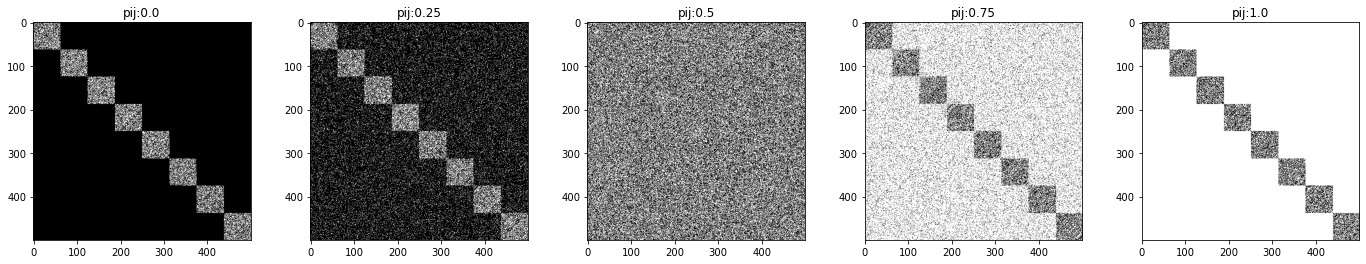

In [3]:
fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].imshow(A_list[i], cmap='gray')
    axes[i].set_title('pij:{}'.format(pij_list[i]))
fig.savefig(os.path.join(path_figures,'Section3-1.pdf'))


### 2. Plot the absolute value of the Fourier transform of your ground truth cluster labels for each SBM realization. To do this, you should one-hot encode your cluster signals into a matrix of dimension N ×K, where the ith column of the matrix has ones in those entries which are part of the ith cluster, and zeros elsewhere. (For example, if your ground truth labels are [0,0,1,1,1], the one hot encoding should be [[1,0],[1,0],[0,1],[0,1],[0,1]]. (There is a clever way to produce this encoding with a single line of code!) You can then take the GFT of the one-hot encoded cluster labels and can plot each column using plt.stem. Make sure that your x-values correspond to the graph frequencies (i.e. eigenvalues).

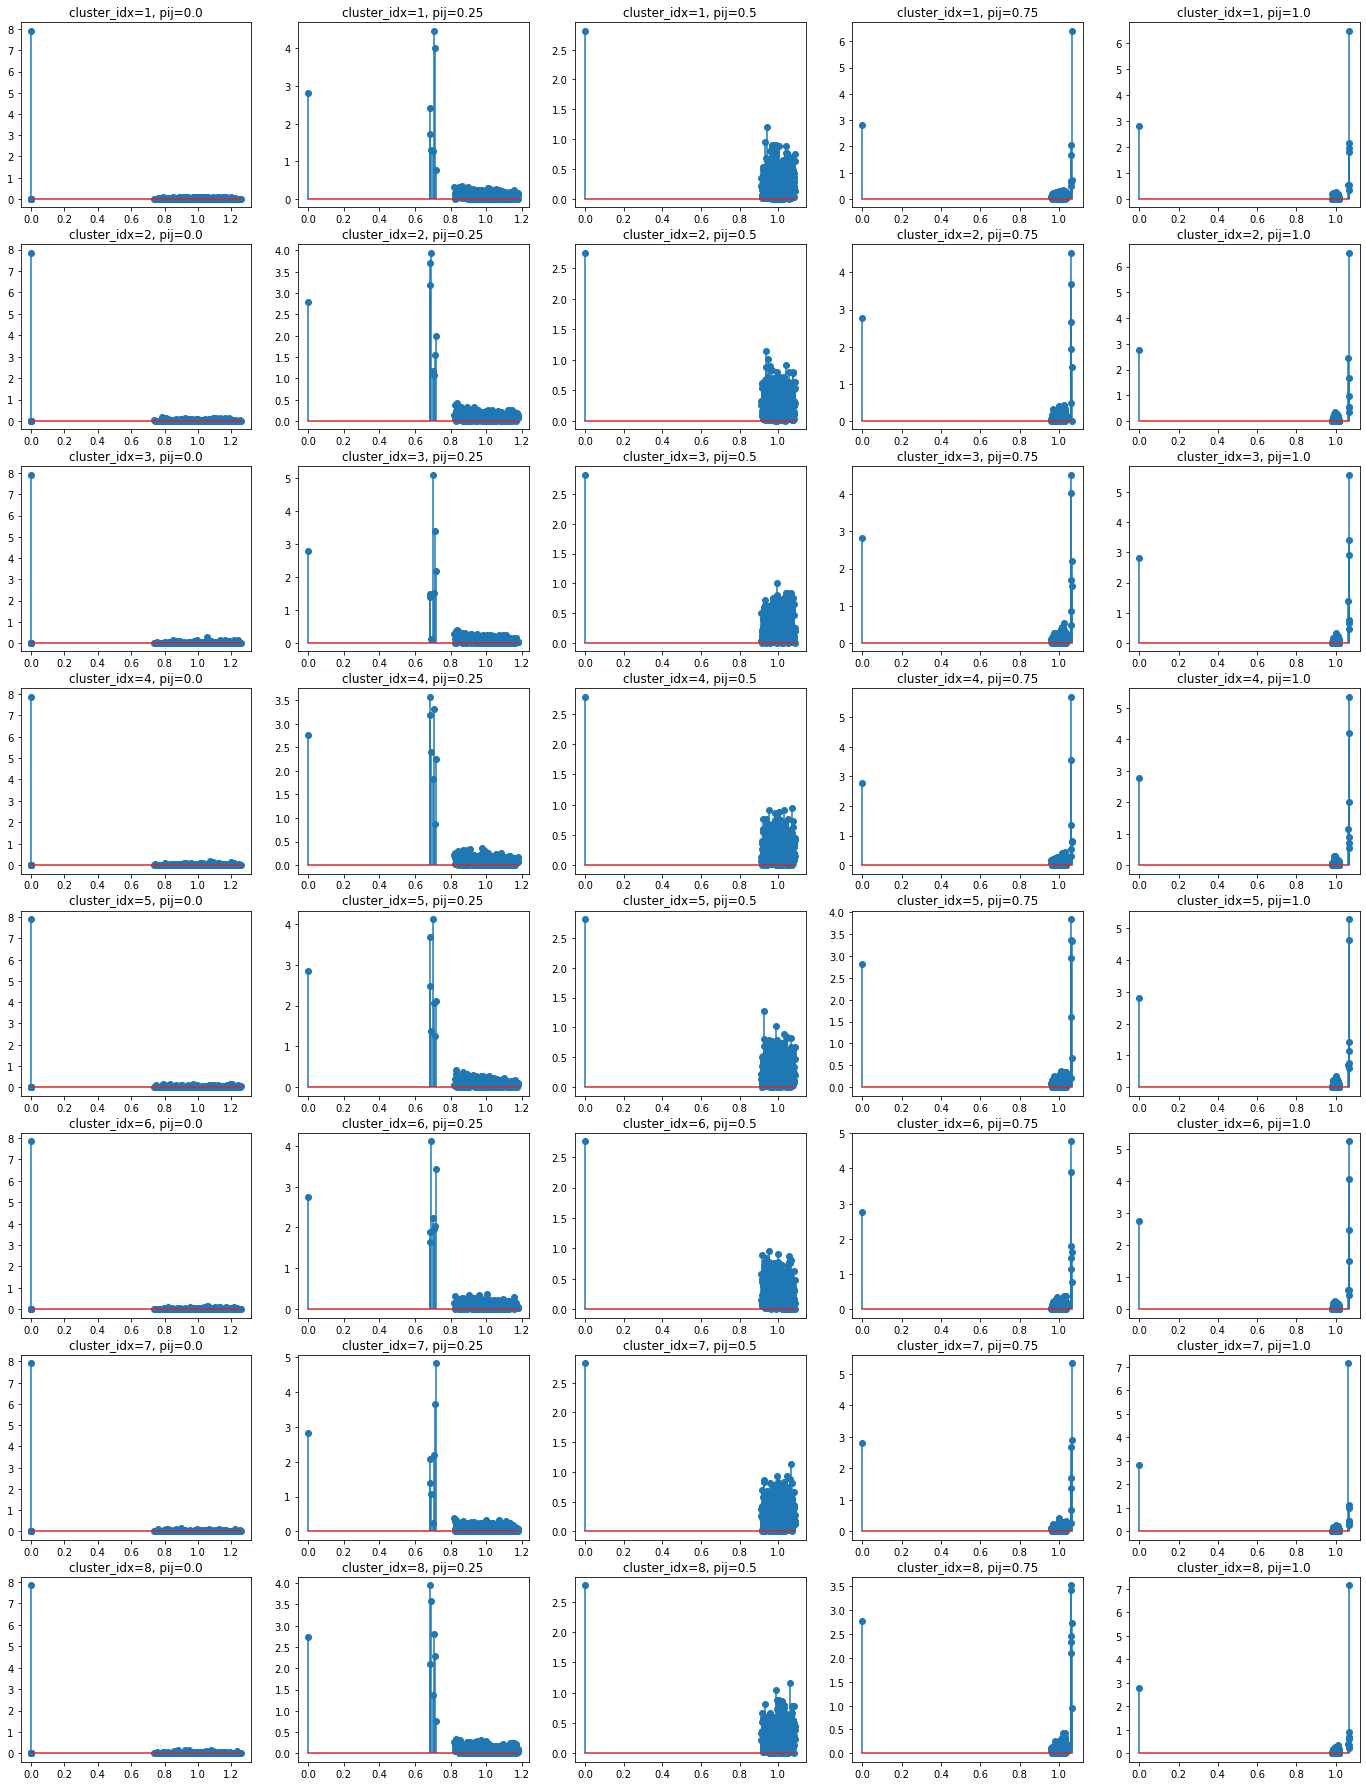

In [4]:
e_list, psi_list = [], []
gt_list_one_hot = []

fig, axes = plt.subplots(k,n_step)
fig.set_size_inches(24,32)

# compute the Graph Fourier Basis
for i in range(n_step):
    Laplacian_matrix = L(A_list[i])
    e, psi = compute_fourier_basis(Laplacian_matrix)
    e_list.append(e), psi_list.append(psi)

# one hot encoding to obtain signal label matrix NxK
for i in range(n_step):
    gt_one_hot = np.eye(k)[gt_list[i].astype(int)[:,0]]
    gt_list_one_hot.append(gt_one_hot)

# Take GFT of label signal
for i in range(n_step):
    gft_gt = gft(gt_list_one_hot[i], psi_list[i])
    for cluster_idx in range(k):
        axes[cluster_idx][i].stem(e_list[i], np.abs(gft_gt[:,cluster_idx]), use_line_collection=True)
        axes[cluster_idx][i].set_title('cluster_idx={cluster_idx}, pij={pij}'.format(cluster_idx = cluster_idx+1, pij=pij_list[i]))
fig.savefig(os.path.join(path_figures,'Section3-2.pdf'))

### 3. At each realization, plot the coordinates of the SBM colored by the second eigenvector of the graph Laplacian.

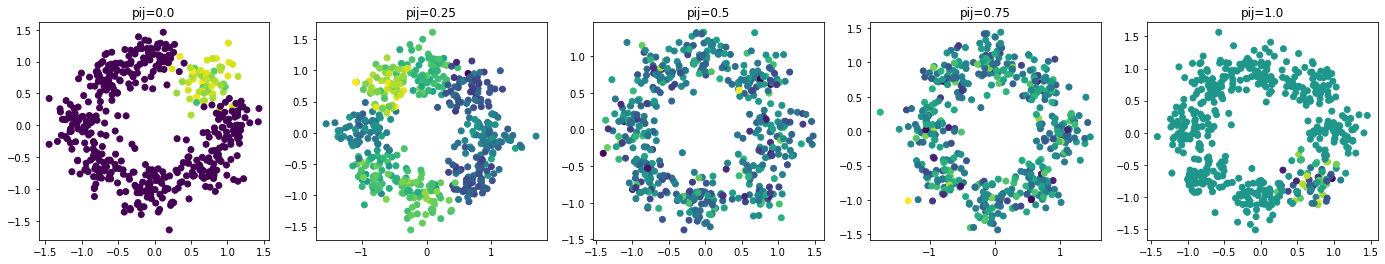

In [5]:
fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=psi_list[i][:,1])
    axes[i].set_title('pij={}'.format(pij_list[i]))
fig.savefig(os.path.join(path_figures,'Section3-3.pdf'))

### 4. Use your filter function to filter random Gaussian noise. Try low pass filters which are ”ideal”, that is, if $\lambda < c$, the filter evaluates to 1. Otherwise, the filter evaluates to 0. Plot the Fourier spectra of a few realizations of Gaussian noise, and plot the filtered noise on the data coordinates.

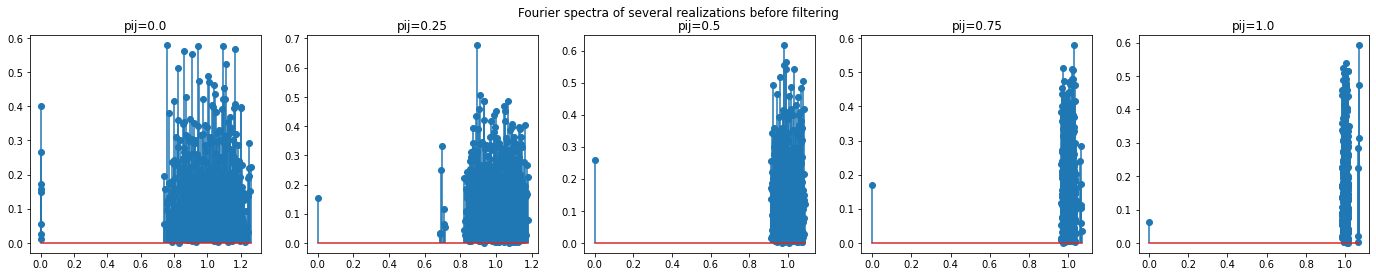

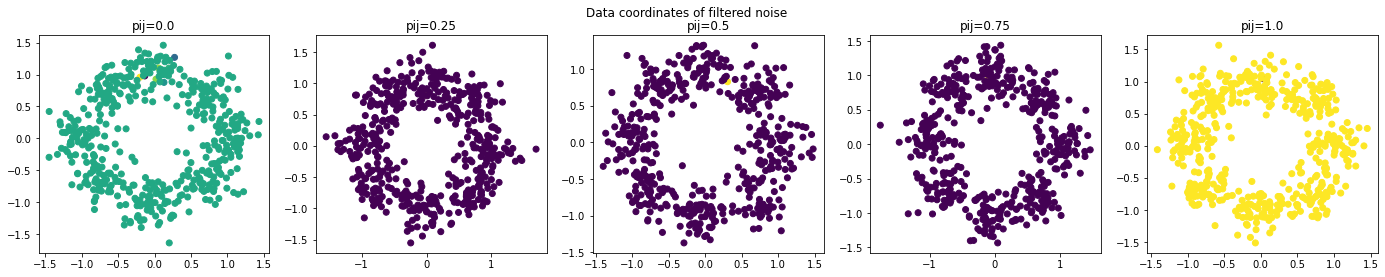

In [6]:
# construct the filtering matrix and Gaussian random noise
H_list, gauss_noise_list = [], []
for i in range(n_step):
    H_list.append(filterbank_matrix(psi_list[i], e_list[i], 'low-pass'))
    gauss_noise_list.append(np.random.normal(scale=sigma, size=(N,1)))

# apply gft for the noise
gauss_noise_gft_list = []
for i in range(n_step):
    gauss_noise_gft_list.append(gft(gauss_noise_list[i],psi_list[i]))

# plot Fourier spectra of several realizations before filtering
fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].stem(e_list[i], np.abs(gauss_noise_gft_list[i]), use_line_collection=True)
    axes[i].set_title('pij={}'.format(pij_list[i]))
fig.suptitle('Fourier spectra of several realizations before filtering')
fig.savefig(os.path.join(path_figures,'Section3-4.pdf'))

# apply gft for the filtered noise
filtered_gauss_noise_gft_list = []
for i in range(n_step):
    filtered_gauss_noise_gft_list.append(gft(H_list[i]@gauss_noise_list[i],psi_list[i]))

# plot filtered noise data coordinates
fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=filtered_gauss_noise_gft_list[i])
    axes[i].set_title('pij={}'.format(pij_list[i]))
fig.suptitle('Data coordinates of filtered noise')
fig.savefig(os.path.join(path_figures,'Section3-5.pdf'))

### Question 3.1: How does the spectrum of the cluster labels changing at various levels of connectedness? What kind of frequency content does a stable clustering have?
Answer: When the connectedness increase (pij from [0, 0.25, 0.5, 0.75, 1]), the frequency gets higher as shown in the spectrum of the cluster labels. A stable clustering has more low frequency components.

### Question 3.2: What do the first few Laplacian eigenvectors represent in the SBM? Why?
Answer: The first few laplacian eigenvectors represent the low frequency components in the SBM. For instance, the first non-null eigenvalue is called Fiedler value and it represents the minmum cut needed
to partition a graph. Its corresponding eigenvectors will guide the partition of the graph given the connectivity.

### Question 3.3: What does the filtered noise look like on average? What happens when you vary the parameter c?
Answer: The unfiltered signals seem to be full of high frequency components which are random noise. After the filtering, the noise seems to be more uniform among various clusters. As we choose c=0.5, 
lower c will result in more low frequency components and higher c will lead to more high frequency components in the spectra.

# 4 Filtering Signals on the Swiss Roll
Using the Swiss roll from Assignment 1, build a graph using the Gaussian kernel parameters that produce a reasonable diffusion map (i.e. it looks like a plane). Use this diffusion map to visualize the signals you generate below.

In [7]:
from ps2_functions import load_json_files
path_swiss_roll_root = os.getcwd().replace('code','data')
swiss_roll_points = load_json_files(os.path.join(path_swiss_roll_root, 'swiss_roll_points.json'))
swiss_roll_labels = load_json_files(os.path.join(path_swiss_roll_root, 'swiss_roll_labels.json'))

from ps1_functions import compute_distances, compute_affinity_matrix, diff_map_info, get_diff_map
def func_DiffuseMap(dataset, kernel_type, t, sigma=None, k=None):
    distance_matrix = compute_distances(dataset)
    affinity_matrix = compute_affinity_matrix(distance_matrix, kernel_type, sigma, k)
    diff_vec, diff_eig = diff_map_info(affinity_matrix)
    diff_map = get_diff_map(diff_vec, diff_eig, t)
    return diff_map, diff_vec, diff_eig

diff_map_sigma3, diff_vec_sigma3, diff_eig_sigma3 = func_DiffuseMap(swiss_roll_points, kernel_type='gaussian', sigma=3, t=1)

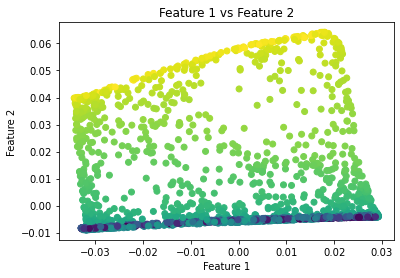

In [8]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(6,4)
axes.scatter(diff_map_sigma3[:,0],diff_map_sigma3[:,1],c=swiss_roll_labels)
axes.set_title('Feature 1 vs Feature 2')
axes.set_xlabel('Feature 1')
axes.set_ylabel('Feature 2')
fig.savefig(os.path.join(path_figures,'Section4-1.pdf'))

### 1. Use the coloring from the previous problem set to generate 3 signals: one low frequency, one medium frequency, one high frequency. Plot these signals and show their graph Fourier transform. Report the function that you used to generate them. Hint: Trigonometric functions work well here.

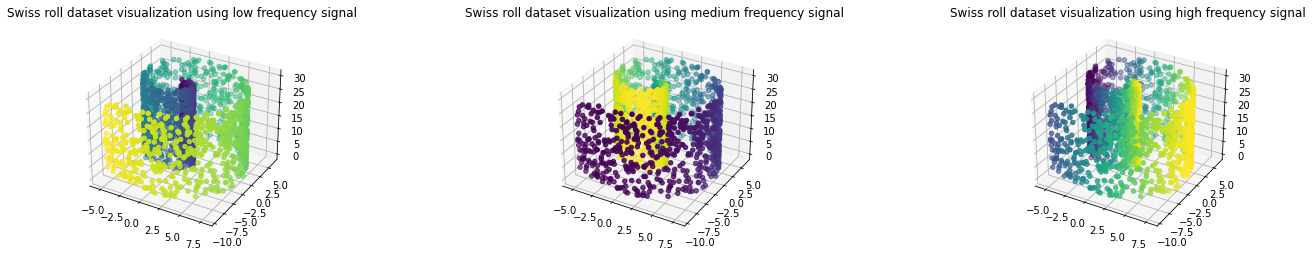

In [9]:
signal_list = [np.sin(freq * swiss_roll_labels) for freq in [0.1, 5, 10]]
freq_type  = ['low', 'medium', 'high']
numOfSignal = int(len(freq_type))

fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(numOfSignal):
    axes = fig.add_subplot(1,3,i+1, projection = '3d')
    axes.scatter(swiss_roll_points[:,0], swiss_roll_points[:,1], swiss_roll_points[:,2], c=signal_list[i])
    axes.set_title('Swiss roll dataset visualization using {} frequency signal'.format(freq_type[i]))
fig.savefig(os.path.join(path_figures,'Section4-2.pdf'))

In [10]:
# compute the fourier basis for the adjacency matrix used in the diffusion map
from ps2_functions import  gaussian_kernel
A_dm = gaussian_kernel(swiss_roll_points, kernel_type='gaussian', sigma=3)
L_dm = L(A_dm, normalized=True)
e_dm, psi_dm = compute_fourier_basis(L_dm)

signal_gft_list = []
for i in range(numOfSignal):
    signal_gft_list.append(gft(signal_list[i], psi_dm))
    print('{} signal graph Fourier transform is {}'.format(freq_type[i], signal_gft_list[i]))

fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
low signal graph Fourier transform is [ 1.76302246e+00 -1.76041515e+00  3.44025163e-02 ... -1.09296168e-03
  1.76193908e-03 -1.61397619e-03]
medium signal graph Fourier transform is [ 1.22191807e+01  2.72929938e+01  1.54700172e+00 ...  1.06589966e-02
 -1.93811164e-02  1.58882886e-02]
high signal graph Fourier transform is [ 1.00917987e+01 -5.46793278e+00 -9.49358693e-01 ...  6.06878737e-03
  5.48792820e-03 -1.84996782e-02]


### 2. Try shifting the phase of your signals. Does it work? You could do this by shifting your trig functions along the color vector.

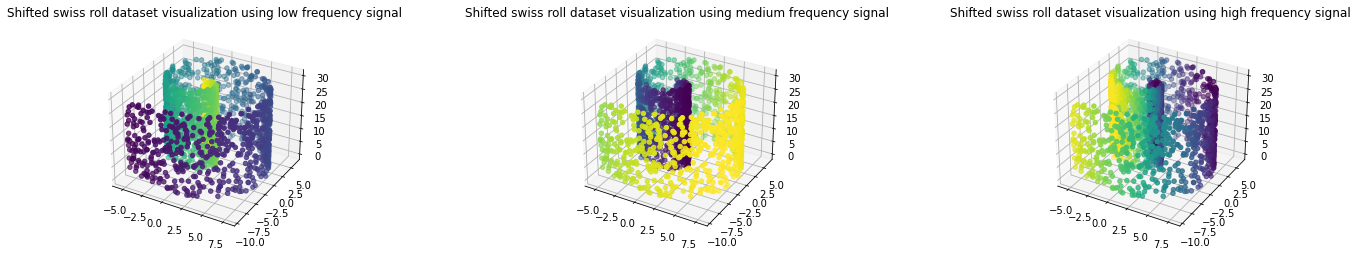

In [11]:
shift_offset = 10
shift_signal_list = [np.sin(freq * swiss_roll_labels + shift_offset) for freq in [0.1, 5, 10]]

fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(numOfSignal):
    axes = fig.add_subplot(1,3,i+1, projection = '3d')
    axes.scatter(swiss_roll_points[:,0], swiss_roll_points[:,1], swiss_roll_points[:,2], c=shift_signal_list[i])
    axes.set_title('Shifted swiss roll dataset visualization using {} frequency signal'.format(freq_type[i]))
fig.savefig(os.path.join(path_figures,'Section4-3.pdf'))

Answer: The shifting works.

### 3. Use your filter function to filter these signals. Try low pass filters which are ”ideal”, that is, if λ < c, the filter evaluates to 1. Otherwise, the filter evaluates to 0. Similarly try ”ideal” high pass filters. Plot the result of two of your favorite filters for your three signals.

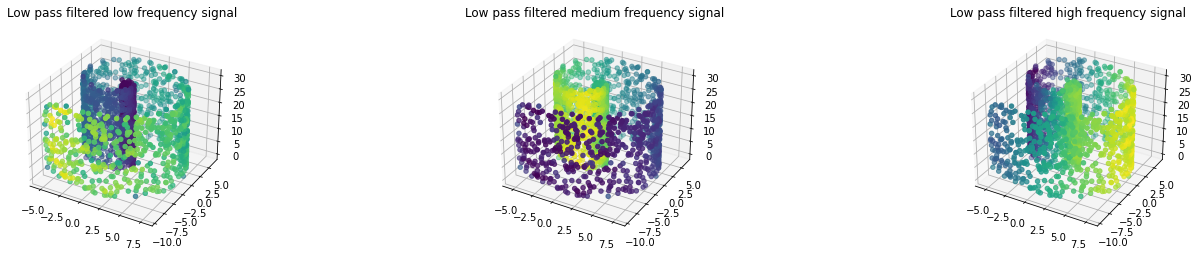

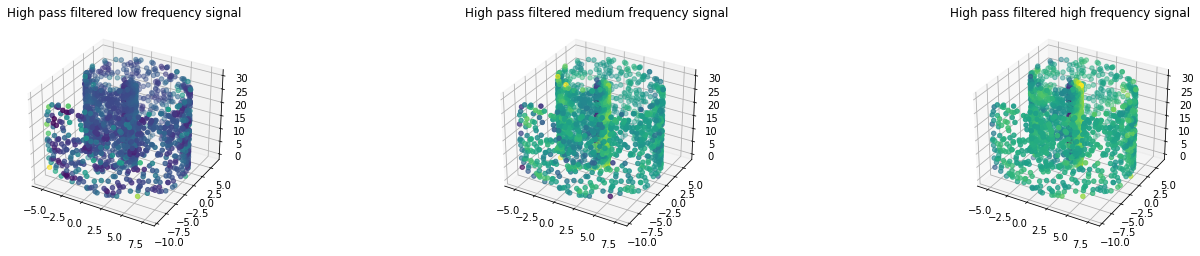

In [12]:
H_dm_lowpass = filterbank_matrix(psi_dm, e_dm, 'low-pass')
H_dm_highpass = filterbank_matrix(psi_dm, e_dm, 'high-pass')

filtered_signal_lowpass_list = [H_dm_lowpass @ signal for signal in signal_list]
filtered_signal_highpass_list = [H_dm_highpass @ signal for signal in signal_list]

# plot low pass figure
fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(numOfSignal):
    axes = fig.add_subplot(1,3,i+1, projection = '3d')
    axes.scatter(swiss_roll_points[:,0], swiss_roll_points[:,1], swiss_roll_points[:,2], c=filtered_signal_lowpass_list[i])
    axes.set_title('Low pass filtered {} frequency signal'.format(freq_type[i]))
fig.savefig(os.path.join(path_figures,'Section4-4.pdf'))

# plot high pass figure
fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(numOfSignal):
    axes = fig.add_subplot(1,3,i+1, projection = '3d')
    axes.scatter(swiss_roll_points[:,0], swiss_roll_points[:,1], swiss_roll_points[:,2], c=filtered_signal_highpass_list[i])
    axes.set_title('High pass filtered {} frequency signal'.format(freq_type[i]))
fig.savefig(os.path.join(path_figures,'Section4-5.pdf'))

### 4. Use the Kronecker delta as a signal to translate your Gaussian to a certain point on the graph. You can do this by taking $H\delta_i$. Changing the value of i should move the Gaussian to different parts of the graph. Translate it over the Swiss roll and note what changing $\lambda_k$ does to the output. Note: In the classical setting, we might call this a Gabor filter.

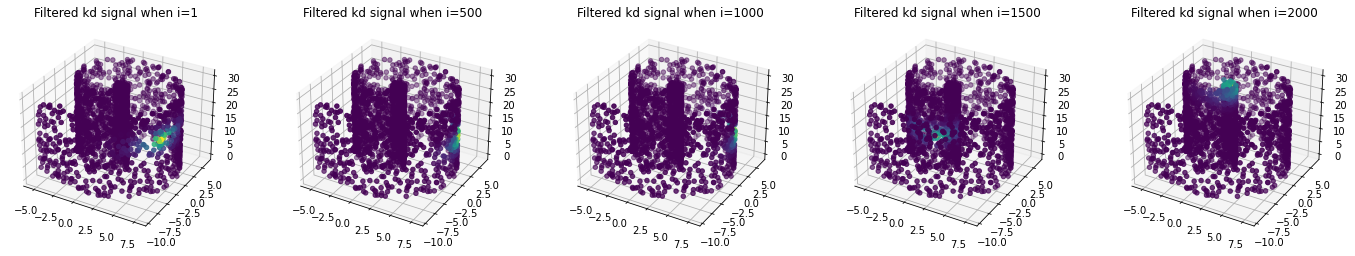

In [13]:
def func_generateKroneckerDelta(i, n):
    vec = np.zeros((n,1))
    vec[i-1] = 1
    return vec

# create the filter matrix for 
H_gauss_dm = filterbank_matrix(psi_dm, e_dm, 'gaussian')

# create various i list
i_list = [1, 500, 1000, 1500, 2000]
signal_KD_list = [func_generateKroneckerDelta(i, H_gauss_dm.shape[0]) for i in i_list]
filtered_signal_KD_list = [H_gauss_dm @ signal_KD for signal_KD in signal_KD_list]

numOfi = int(len(i_list))

# plot high pass figure
fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(numOfi):
    axes = fig.add_subplot(1,5,i+1, projection = '3d')
    axes.scatter(swiss_roll_points[:,0], swiss_roll_points[:,1], swiss_roll_points[:,2], c=filtered_signal_KD_list[i])
    axes.set_title('Filtered kd signal when i={}'.format(i_list[i]))
fig.savefig(os.path.join(path_figures,'Section4-6.pdf'))

### 5. Plot all of your filters by evaluating them over the interval [0, $\lambda_N$ ). You can use np.linspace(0,lmax,1000) where lmax is the largest eigenvalue of the Laplacian.

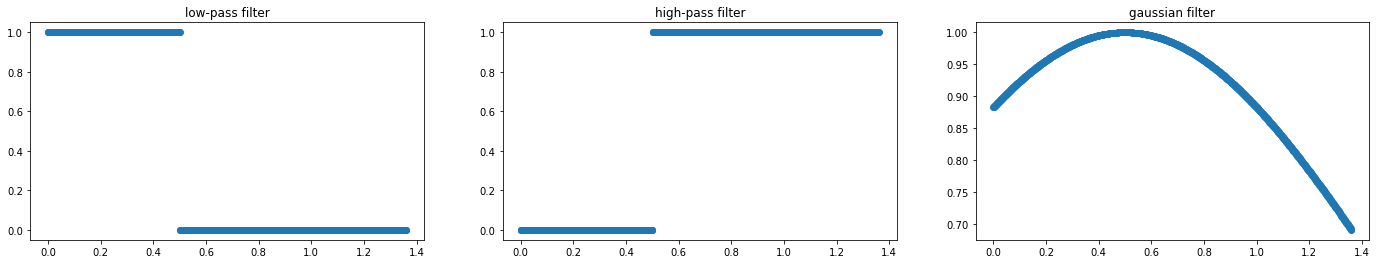

In [14]:
def func_generateFilteredEigValue(e, h):
    assert h in ['low-pass','high-pass','gaussian']
    c = 1/2 # threshold for low-pass and high-pass filter
    mu = 0.5
    sigma = 1

    e_filtered = np.zeros(e.shape)
    N = e.shape[0]
    if h == 'low-pass':
        for i in range(N):
            if e[i] < c:
                e_filtered[i] = 1
            else:
                e_filtered[i] = 0
    
    if h == 'high-pass':
        for i in range(N):
            if e[i] > c:
                e_filtered[i] = 1
            else:
                e_filtered[i] = 0

    if h =='gaussian':
        for i in range(N):
            e_filtered[i] = np.exp(-(e[i]-mu)**2/(2*sigma**2))

    return e_filtered

e_dm_max = np.max(e_dm)
eig_arr = np.linspace(0, e_dm_max, 1000)
filtered_eig_arr_list = []

filter_name_list = ['low-pass','high-pass','gaussian']
numOfFilter = int(len(filter_name_list))

for filter_name in filter_name_list:
    filtered_eig_arr_list.append(func_generateFilteredEigValue(eig_arr, filter_name))

fig, axes = plt.subplots(1,numOfFilter)
fig.set_size_inches(24,4)
for i in range(numOfFilter):
    axes[i].scatter(eig_arr, filtered_eig_arr_list[i])
    axes[i].set_title('{} filter'.format(filter_name_list[i]))
fig.savefig(os.path.join(path_figures,'Section4-7.pdf'))


### Question 4.1: What does smoothness mean in terms of graph signals and their frequency spectrum?
Answer: The smoothness is defined using the graph signal laplacian matrix. Frequency spectrum is the eigenvalue of the laplacian matrix, which defines the smoothness. Thus, if the frequency spectrum has more high freqeuncy components, it is less smooth and vice versa.

### Question 4.2: Band-limiting is a nice trait if one wants to design an algorithm. It means that there is no frequency content above a certain frequency, i.e. the band limit. For what values of pij are SBM cluster labels band-limited?
Answer: From the figure in section 3, when pij = 0, the band limit is about 1.2. For other values of pij (0.25, 0.5, 0.75, 1), the band limit is about 1.1.

### Question 4.3: Under what scenarios would you want a band pass or high pass filter? How do these filters work and what do they do to the spectrum of the signals?
Answer: If we want to retain the high frequency components, we want a high pass filter. If we want to retain information in a certain frequency range, we use a band pass filter. An ideal high pass filter will discard frequency below a certain threshold and retain all the frequency above. Band pass will utilize a gaussian function for frequency spectrum.

### Question 4.4: (Bonus) Are there any similarities between the band pass experiment and classical translation and modulation?
Answer: There are similarities between band pass experiment and classical modulation. Band pass filter will amplify the Gaussian part of the signal, which is similar to modulation.

# 5 k-means Clustering
Please refer to ps2_functions.py for kmeans() and kmeansplusplus() function.
### 1. Run k-means on your GMM with various values of sigma.

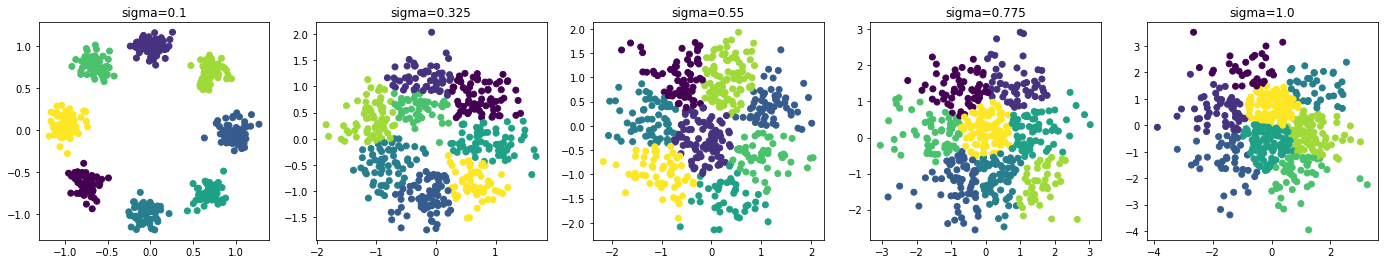

In [15]:
pii = 0.8
pij = 0.5
N = 500
k = 8
sigma_list = []
n_step = 5

A_list, gt_list, coords_list = [], [], []

for sigma in np.linspace(0.1,1,n_step):
    A, gt, coords = sbm(N, k, pij, pii, sigma)
    A_list.append(A)
    gt_list.append(gt)
    coords_list.append(coords)
    sigma_list.append(sigma)

k_means_label_list = [kmeans(coords, k=k) for coords in coords_list]

fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=k_means_label_list[i])
    axes[i].set_title('sigma={}'.format(sigma_list[i]))
fig.savefig(os.path.join(path_figures,'Section5-1.pdf'))

### 2. Next, generate a concentric spherical dataset by sampling 1000 points from a 3d unit normal distribu- tion. Normalize all points using Euclidean distance. This should form a hollow sphere. Multiply the first 500 points by 10. This should create concentric spheres. Each sphere will be a separate cluster. Run k-means on this.


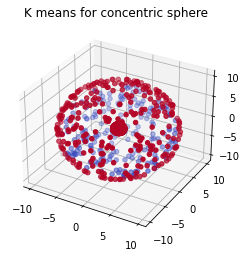

In [16]:
from matplotlib import cm
# generate the concentric dataset
mean = np.zeros((3,))
cov = np.eye(3)
numOfSample = 1000

sphere_concentric = np.random.multivariate_normal(mean, cov, size=numOfSample)

# normalize the sphere based on the Euclidean distance
for i in range(numOfSample):
    sphere_concentric[i,:] /= np.linalg.norm(sphere_concentric[i,:])
    if i < 500:
        sphere_concentric[i,:] *= 10
        
kmeans_label_concentric_sphere = kmeans(sphere_concentric, k=2)

fig = plt.figure()
axis = fig.add_subplot(1,1,1, projection='3d')
axis.scatter(sphere_concentric[:,0], sphere_concentric[:,1], sphere_concentric[:,2], c=kmeans_label_concentric_sphere, cmap=cm.coolwarm)
axis.set_title('K means for concentric sphere')
fig.savefig(os.path.join(path_figures,'Section5-2.pdf'))

### Question 5.1: Compare the labels you obtain on the SBM to the ground truth clusters. At what values of sigma does k-means clustering start to fail?
Answer: The cluster starts to fail when sigma = 0.55 from the figure in section 1.

### Question 5.2: Does k-means converge to a reasonable clustering on the concentric spheres? Why?
Answer: K-means does not converge to a reasonable clustering because the mean of the concentric spheres are both zeros.

# 6 Spectral Clustering
Please refer to the function SC() for details.

### 1. Run spectral clustering on your SBM with various values of sigma and pij.


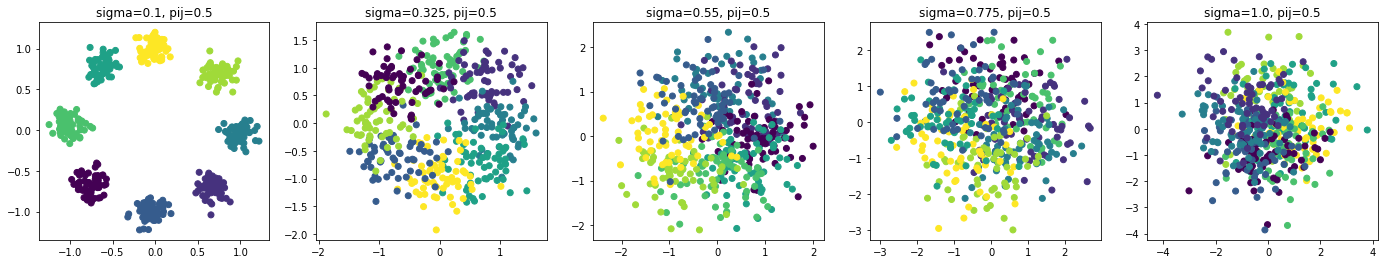

In [17]:
pii = 0.8
pij_list = []
N = 500
k = 8
sigma_list = []
n_step = 5
pij = 0.5

# Experiment for varying sigma
A_list, gt_list, coords_list = [], [], []
for sigma in np.linspace(0.1,1,n_step):
    A, gt, coords = sbm(N, k, pij, pii, sigma)
    A_list.append(A)
    gt_list.append(gt)
    coords_list.append(coords)
    sigma_list.append(sigma)

SC_list = []
for i in range(n_step):
    L_matrix = L(A_list[i])
    SC_list.append(SC(L_matrix, k))

fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=SC_list[i])
    axes[i].set_title('sigma={}, pij=0.5'.format(sigma_list[i]))
fig.savefig(os.path.join(path_figures,'Section6-1.pdf'))

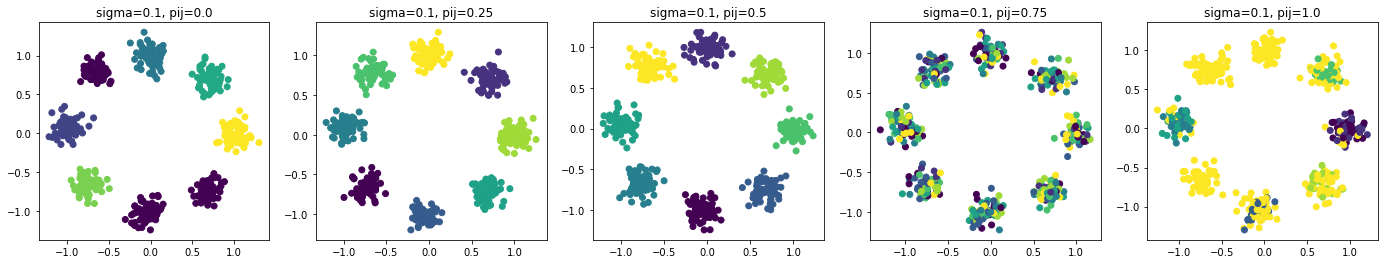

In [18]:
A_list, gt_list, coords_list = [], [], []
for pij in np.linspace(0,1,n_step):
    A, gt, coords = sbm(N, k, pij, pii, sigma=0.1)
    A_list.append(A)
    gt_list.append(gt)
    coords_list.append(coords)
    pij_list.append(pij)

SC_list = []
for i in range(n_step):
    L_matrix = L(A_list[i])
    SC_list.append(SC(L_matrix, k))

fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=SC_list[i])
    axes[i].set_title('sigma=0.1, pij={}'.format(pij_list[i]))

fig.savefig(os.path.join(path_figures,'Section6-2.pdf'))

### 2. Next, generate a concentric spherical dataset by sampling 1000 points from a 3d unit normal distri- bution. Normalize all points using L2 distance. This should form a hollow sphere. Multiply the first 500 points by 10. This should create concentric spheres. Each sphere will be a separate cluster. Use a Gaussian kernel to generate a graph for these spheres. Run spectral clustering on this.

fixed bandwidth specified


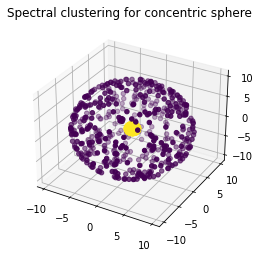

In [19]:
gauss_kernel_sphere_concentric = gaussian_kernel(sphere_concentric)
L_sphere_concentric = L(gauss_kernel_sphere_concentric)
SC_sphere_concentric = SC(L_sphere_concentric, k=2)

fig = plt.figure()
axis = fig.add_subplot(1,1,1, projection='3d')
axis.scatter(sphere_concentric[:,0], sphere_concentric[:,1], sphere_concentric[:,2], c=SC_sphere_concentric)
axis.set_title('Spectral clustering for concentric sphere')
fig.savefig(os.path.join(path_figures,'Section6-3.pdf'))

### 3. Generate multiple instantiations of Gaussian noise on the concentric spheres (vary the variance of the noise) and filter them using an ideal low-pass filter.

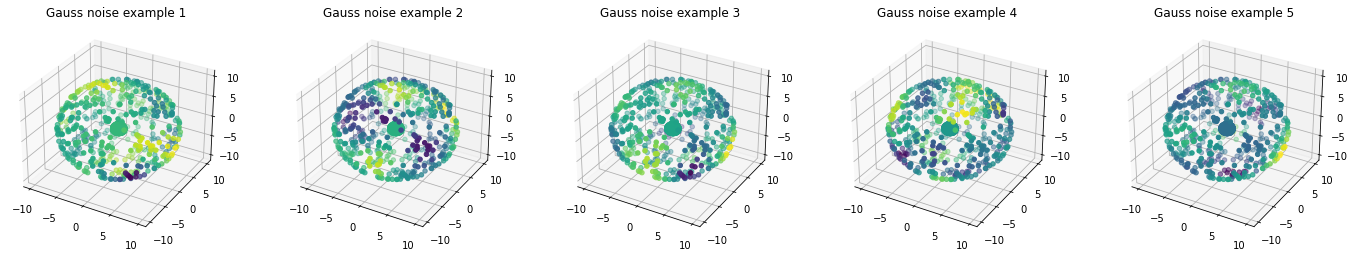

In [20]:
# generate the noise signal
n_example = 5
gauss_noise_list = []
for i in range(n_example):
    gauss_noise_list.append(np.random.normal(size=(numOfSample,1)))

# compute the filtering matrix
e_sphere, psi_sphere = compute_fourier_basis(L_sphere_concentric)
H_sphere = filterbank_matrix(psi_sphere, e_sphere, 'low-pass')

# compute the filtered noise signal
filtered_noise_list = []
for gauss_noise in gauss_noise_list:
    filtered_noise_list.append(H_sphere @ gauss_noise)

fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(n_example):
    axes = fig.add_subplot(1,n_example,i+1, projection = '3d')
    axes.scatter(sphere_concentric[:,0], sphere_concentric[:,1], sphere_concentric[:,2], c=filtered_noise_list[i])
    axes.set_title('Gauss noise example {}'.format(i+1))

fig.savefig(os.path.join(path_figures,'Section6-4.pdf'))


### 4. Finally, use your SBM to generate coordinates (as in regular k-means), but generate an adjacency matrix for these points using the Gaussian kernel (This concoction is called a Gaussian Mixture Model). Perform spectral clustering on this at various bandwidths.

fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth


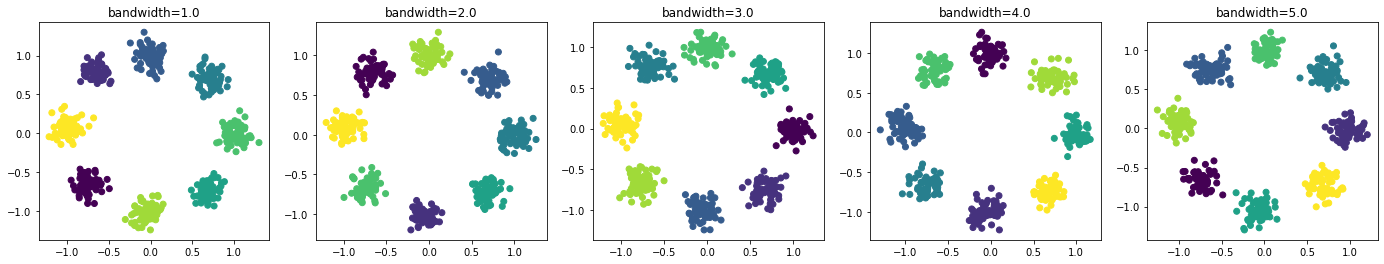

In [21]:
pii = 0.8
N = 500
k = 8
sigma = 0.1
n_step = 5
pij = 0.5

A, gt, coords = sbm(N, k, pij, pii, sigma)

bandwidth_range = np.linspace(1, 5, n_step)

L_list = []
for bandwidth in bandwidth_range:
    gauss_kernel = gaussian_kernel(A, sigma=bandwidth)
    L_list.append(L(gauss_kernel))

SC_GMM_list = []
for L_matrix in L_list:
    SC_GMM_list.append(SC(L_matrix, k))

fig, axes = plt.subplots(1,n_step)
fig.set_size_inches(24,4)
for i in range(n_step):
    axes[i].scatter(coords_list[i][:,0], coords_list[i][:,1], c=SC_GMM_list[i])
    axes[i].set_title('bandwidth={}'.format(bandwidth_range[i]))

fig.savefig(os.path.join(path_figures,'Section6-5.pdf'))

### 5. Compare these results to the ones you found in our initial k-means experiment.
Answer: The spectral clustering is better compared with the initial k-means methods for GMM models and especially for the concentric sphere data. Original k-means is not able to create a reasonable graph while spectral clustering successfully seperate the two spheres.

### Question 6.1 Compare the labels you obtain on the SBM to the ground truth clusters. At what values of sigma and pij does spectral clustering start to fail?
Answer: When sigma = 0.1, spectral clustering starts to fail when pij = 0.75 in the test. When pij = 0.5, spectral clustering starts to fail when sigma = 0.325.

### Question 6.2 How does spectral clustering compare to k-means on the SBM? How does using the SBM adjacency matrix compare to creating one from a Gaussian kernel?
Answer: The spectral clustering is better compared with the initial k-means methods for GMM models. Using a Gaussian kernel provides a better performance than using SBM adjacency matrix.

### Question 6.3 How does spectral clustering compare to k-means on the concentric spheres?
Answer: Spectral clustering is better than k-means on concentric spheres and provides a reasonable seperation between two spheres.

### Question 6.4 How does the kernel width affect the output of the clustering?
Answer: The kernel bandwidth does not affect too much the output of the clustering.

### Question 6.5 Compare the cluster labels of spectral clustering to the filtered noise on the concentric spheres. What is the frequency content of the label vector? Discuss the connection between Spectral clustering and the Graph Fourier Transform.
Answer: The frequency of the label vector corresponds to the low-frequency components after the filtering. Spectral clustering will only retain the smallest-k components while Graph fourier transform retains all the components.

### Question 6.6 In the case that you don’t have some pathological geometry (i.e. the concentric spheres), when would you use spectral clustering?
Answer: As spectral clustering contains a dimensionality reduction by selecting the smallest k eigenvectors, it might work well for high-dimensional data.

# 7 Using Louvain, and trying out PHATE and tSNE
### 1. First, run Louvain on each of our past examples. Try it on the SBM graphs for a few values of pij. Experiment with Louvain on the GMM, with different sigmas. Lastly, try Louvain on the concentric spheres.

In [56]:
pii = 0.8
N = 500
k = 8
sigma = 0.1
n_step = 5

# generate SBM dataset with different values of pij
A_list_SBM, gt_list_SBM, coords_list_SBM = [], [], []
pij_list_SBM = []
for pij in np.linspace(0,1,n_step):
    A, gt, coords = sbm(N, k, pij, pii, sigma=0.1)
    A_list_SBM.append(A)
    gt_list_SBM.append(gt)
    coords_list_SBM.append(coords)
    pij_list_SBM.append(pij)

# generate GMM with different values of sigma
pij = 0.5
A_GMM, gt_GMM, coords_GMM = sbm(N, k, pij, pii, sigma)

bandwidth_range = np.linspace(1, 5, n_step)

gauss_kernel_GMM_list = []
bandwidth_GMM_list = []
for bandwidth in bandwidth_range:
    gauss_kernel_GMM_list.append(gaussian_kernel(coords_GMM, sigma=bandwidth))
    bandwidth_GMM_list.append(bandwidth)
    
# generate concentric sphere dataset
mean = np.zeros((3,))
cov = np.eye(3)
numOfSample = 1000
sphere_concentric = np.random.multivariate_normal(mean, cov, size=numOfSample)
for i in range(numOfSample):
    sphere_concentric[i,:] /= np.linalg.norm(sphere_concentric[i,:])
    if i < 500:
        sphere_concentric[i,:] *= 10

gauss_kernel_sphere_concentric = gaussian_kernel(sphere_concentric)


fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth
fixed bandwidth specified


In [57]:
import networkx as nx
from community import community_louvain

def func_Louvain(A_matrix, resolution = 1):
    # generate cluster label using Louvain
    G = nx.from_numpy_array(A_matrix)
    partition = community_louvain.best_partition(G, resolution=resolution)
    clusters_labels = list(partition.values())

    return clusters_labels

# run Louvain on SBM dataset with various pij and resolution
SBM_Louvain_list = []
for i in range(n_step):
    SBM_Louvain_fix_res_list = []
    for resolution in np.linspace(0.1, 1, n_step):
        SBM_Louvain_fix_res_list.append(func_Louvain(A_list_SBM[i], resolution = resolution))
    SBM_Louvain_list.append(SBM_Louvain_fix_res_list)

# run Louvain on GMM dataset with various sigma and resolution
GMM_Louvain_list = []
for i in range(n_step):
    GMM_Louvain_fix_res_list = []
    for resolution in np.linspace(0.1, 1, n_step):
        GMM_Louvain_fix_res_list.append(func_Louvain(gauss_kernel_GMM_list[i], resolution = resolution))
    GMM_Louvain_list.append(SBM_Louvain_fix_res_list)

# run Louvain on concentric sphere dataset
sphere_Louvain_list = []
for resolution in np.linspace(0.1, 1, n_step):
    sphere_Louvain_list.append(func_Louvain(gauss_kernel_sphere_concentric, resolution=resolution))

### 2. Visualize your Louvain clusterings by coloring scatterplots of each model with Louvain’s cluster labels, as previously. Try varying Louvain’s resolution parameter, while observing the effects on your colored scatterplots.

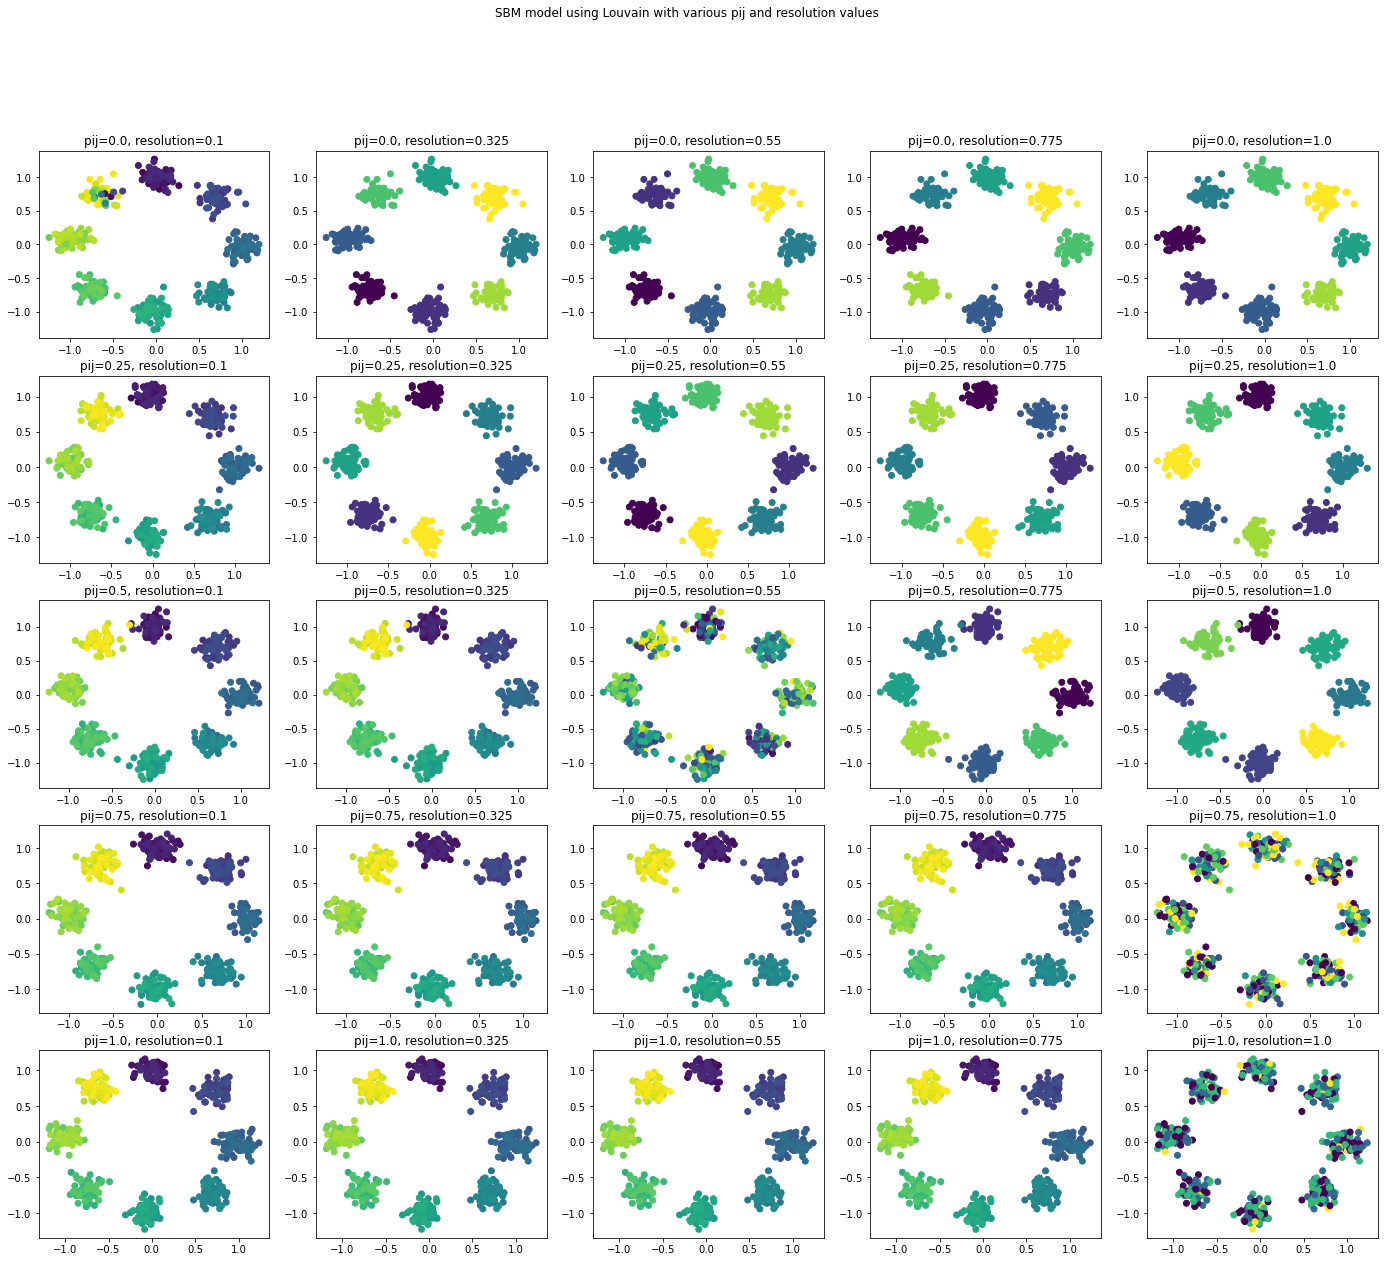

In [42]:
resolution_list = [resolution for resolution in np.linspace(0.1, 1, n_step)]

# visualize SBM model
fig, axes = plt.subplots(n_step,n_step)
fig.set_size_inches(24,20)

for i in range(n_step):
    for res_index in range(n_step):
        axes[i][res_index].scatter(coords_list_SBM[i][:,0], coords_list_SBM[i][:,1], c=SBM_Louvain_list[i][res_index])
        axes[i][res_index].set_title('pij={pij}, resolution={resolution}'.format(pij=pij_list_SBM[i], resolution=resolution_list[res_index]))
fig.suptitle('SBM model using Louvain with various pij and resolution values')
fig.savefig(os.path.join(path_figures,'Section7-1.pdf'))

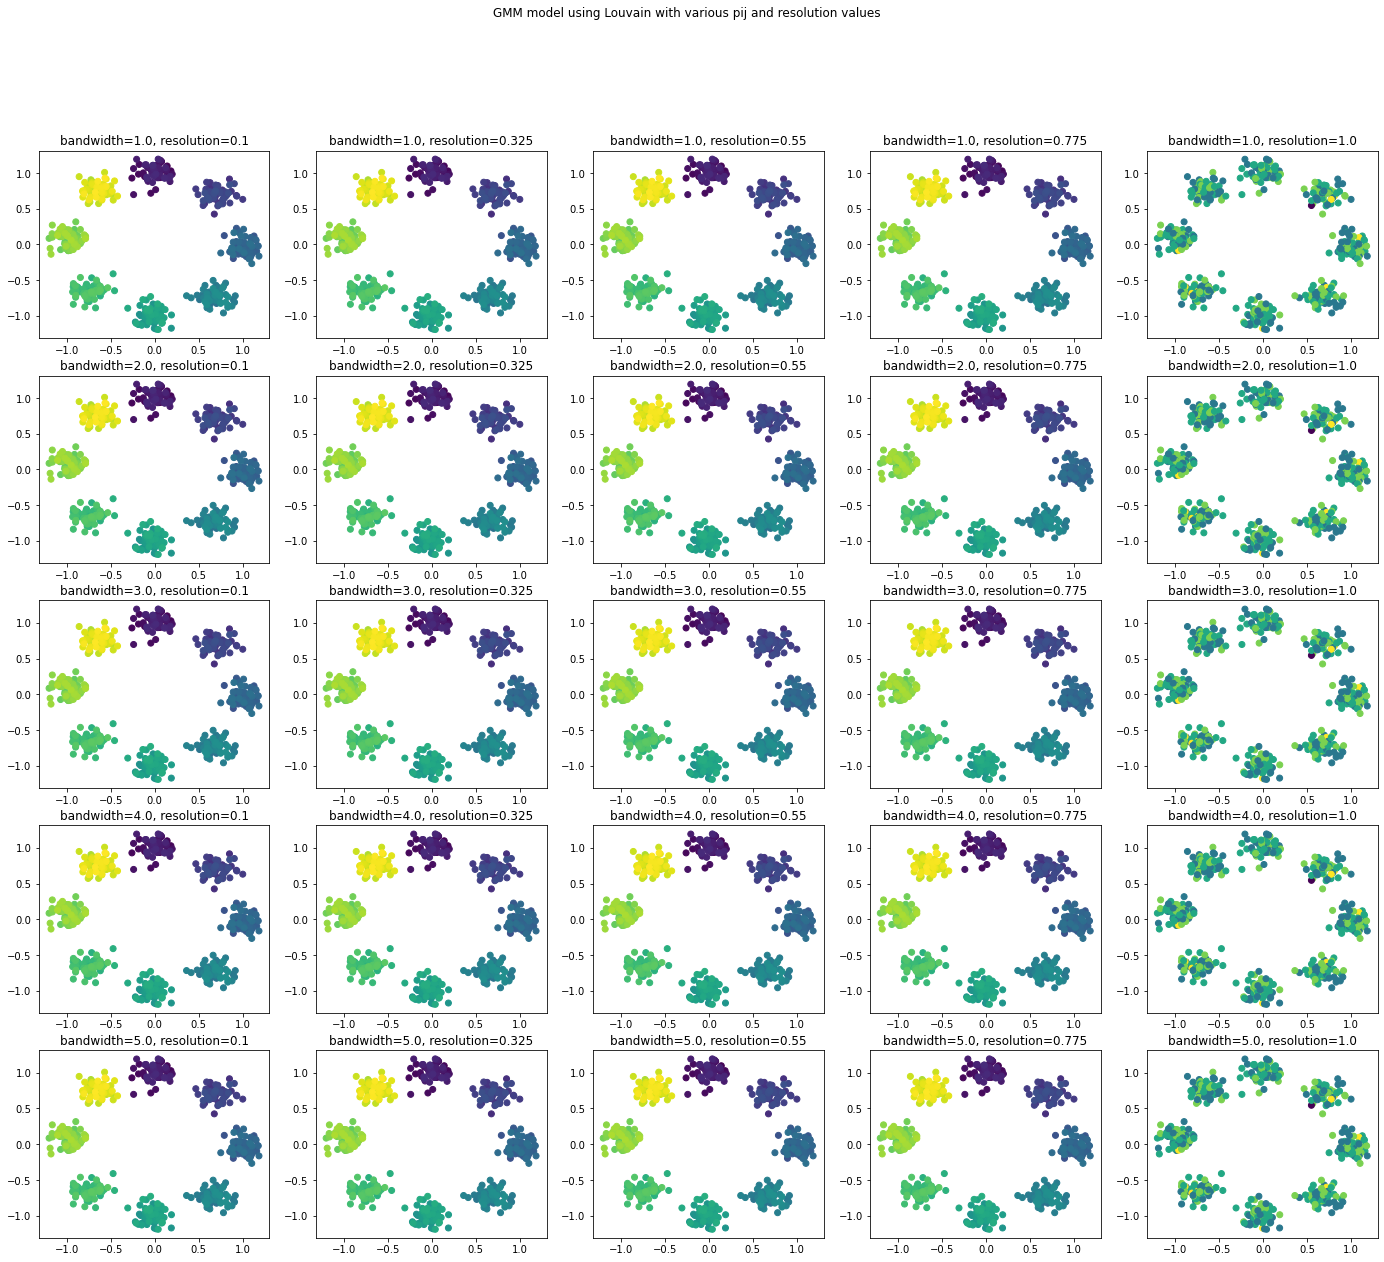

In [59]:
# visualize GMM model
fig, axes = plt.subplots(n_step,n_step)
fig.set_size_inches(24,20)

for i in range(n_step):
    for res_index in range(n_step):
        axes[i][res_index].scatter(coords_GMM[:,0], coords_GMM[:,1], c=GMM_Louvain_list[i][res_index])
        axes[i][res_index].set_title('bandwidth={bandwidth}, resolution={resolution}'.format(bandwidth=bandwidth_GMM_list[i], resolution=resolution_list[res_index]))
        
fig.suptitle('GMM model using Louvain with various pij and resolution values')
fig.savefig(os.path.join(path_figures,'Section7-2.pdf'))

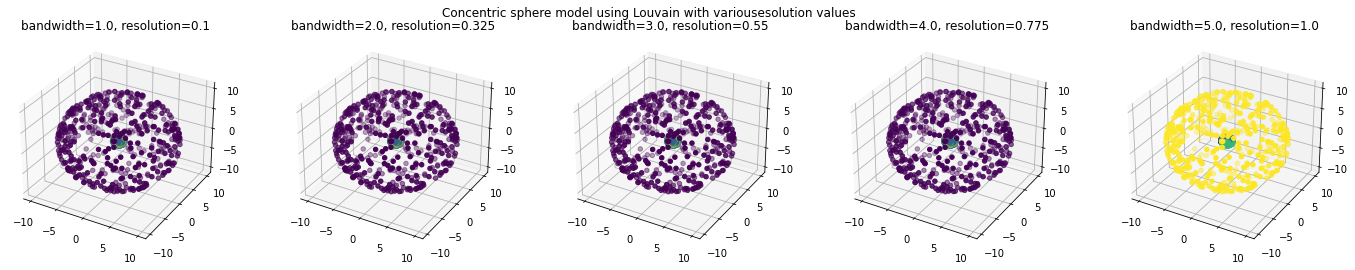

In [46]:
# visualize concentric sphere

fig = plt.figure()
fig.set_size_inches(24,4)

for res_index in range(n_step):
    axes = fig.add_subplot(1,n_step,res_index+1, projection = '3d')
    axes.scatter(sphere_concentric[:,0], sphere_concentric[:,1], sphere_concentric[:,2], c=sphere_Louvain_list[res_index])
    axes.set_title('bandwidth={bandwidth}, resolution={resolution}'.format(bandwidth=bandwidth_GMM_list[res_index], resolution=resolution_list[res_index]))
        
fig.suptitle('Concentric sphere model using Louvain with variousesolution values')
fig.savefig(os.path.join(path_figures,'Section7-3.pdf'))

### 3. Using tSNE, visualize the best clustering you found with Louvain. You can use the scikit-learn implementation of tSNE. Create at least six visualizations by varying the parameters of tSNE to find the optimal representation of Louvain’s clusters. You can find a nice explanation of tSNE’s parameters here: https://distill.pub/2016/misread-tsne/.

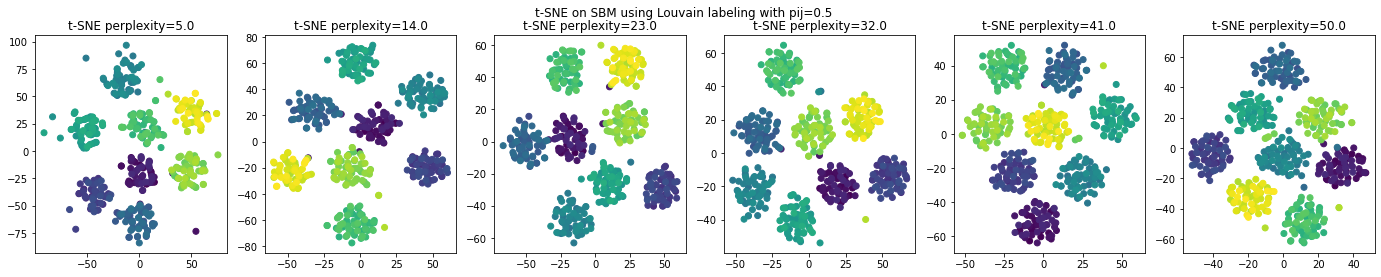

In [54]:
from sklearn.manifold import TSNE
n_example = 6
perplexity_range = np.linspace(5, 50, n_example)

# SBM dataset
fig, axes = plt.subplots(1,n_example)
fig.set_size_inches(24,4)
for i in range(n_example):
    SBM_tsne = TSNE(n_components=2, perplexity = perplexity_range[i]).fit_transform(A_list_SBM[2]) # A_list_SBM index = 2 means pij=0.5
    axes[i].scatter(SBM_tsne[:,0], SBM_tsne[:,1], c=SBM_Louvain_list[2][0]) # SBM_Louvain_list index = 2 means pij=0.5
    axes[i].set_title('t-SNE perplexity={}'.format(perplexity_range[i]))

fig.suptitle('t-SNE on SBM using Louvain labeling with pij=0.5')
fig.savefig(os.path.join(path_figures,'Section7-4.pdf'))

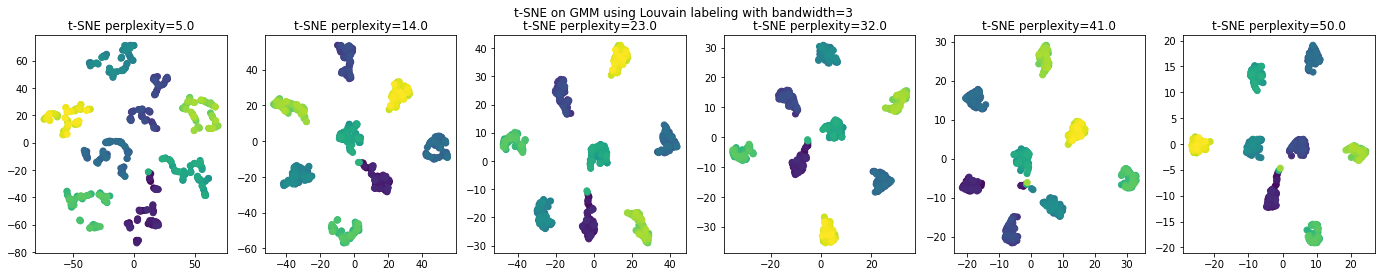

In [58]:
# GMM model
fig, axes = plt.subplots(1,n_example)
fig.set_size_inches(24,4)
for i in range(n_example):
    GMM_tsne = TSNE(n_components=2, perplexity = perplexity_range[i]).fit_transform(gauss_kernel_GMM_list[2]) # gauss_kernel_GMM_list = 2 means bandwidth = 3
    axes[i].scatter(GMM_tsne[:,0], GMM_tsne[:,1], c=GMM_Louvain_list[2][0]) # GMM_Louvain_list index = 2 means bandwidth = 3
    axes[i].set_title('t-SNE perplexity={}'.format(perplexity_range[i]))

fig.suptitle('t-SNE on GMM using Louvain labeling with bandwidth=3')
fig.savefig(os.path.join(path_figures,'Section7-5.pdf'))

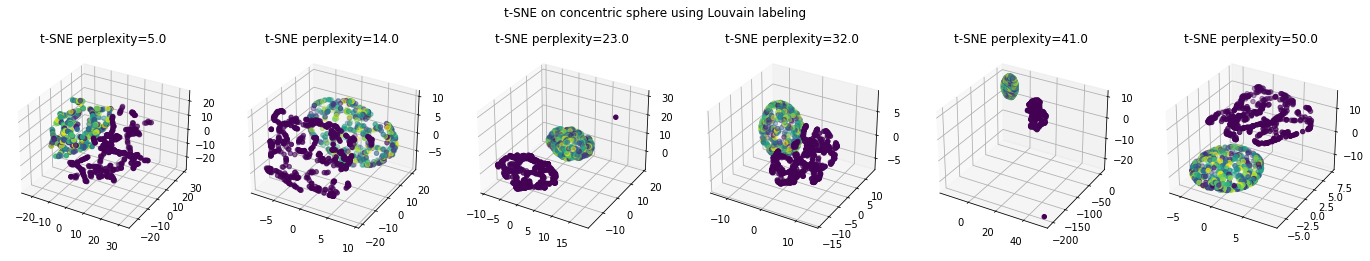

In [61]:
# concentric sphere
fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(n_example):
    sphere_tsne = TSNE(n_components=3, perplexity = perplexity_range[i]).fit_transform(gauss_kernel_sphere_concentric)
    axes = fig.add_subplot(1,n_example,i+1, projection = '3d')
    axes.scatter(sphere_tsne[:,0], sphere_tsne[:,1], sphere_tsne[:,2], c=sphere_Louvain_list[0])
    axes.set_title('t-SNE perplexity={}'.format(perplexity_range[i]))

fig.suptitle('t-SNE on concentric sphere using Louvain labeling')
fig.savefig(os.path.join(path_figures,'Section7-6.pdf'))

### 4. Now, visualize the Louvain clusters using PHATE. The PHATE package is also available on PyPI (use pip install phate), and its usage instructions are here: https://phate.readthedocs.io/en/stable/. As before, create at least six visualizations of PHATE with different parameters.

Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.17 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.31 seconds.
Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating diffusion potential...
 

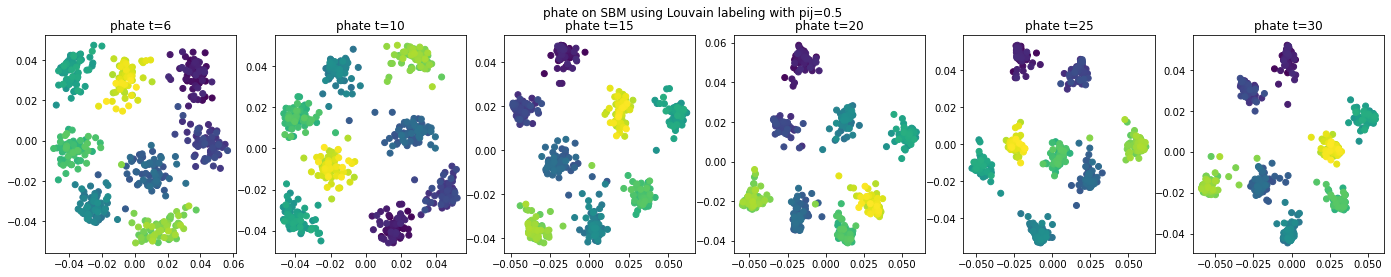

In [67]:
import phate
n_example = 6
t_range = np.linspace(6,30,n_example)

# SBM dataset
fig, axes = plt.subplots(1,n_example)
fig.set_size_inches(24,4)
for i in range(n_example):
    SBM_phate = phate.PHATE(t = int(t_range[i])).fit_transform(A_list_SBM[2]) # A_list_SBM index = 2 means pij=0.5
    axes[i].scatter(SBM_phate[:,0], SBM_phate[:,1], c=SBM_Louvain_list[2][0]) # SBM_Louvain_list index = 2 means pij=0.5
    axes[i].set_title('phate t={}'.format(int(t_range[i])))

fig.suptitle('phate on SBM using Louvain labeling with pij=0.5')
fig.savefig(os.path.join(path_figures,'Section7-7.pdf'))

Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.29 seconds.
Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.18 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calcula

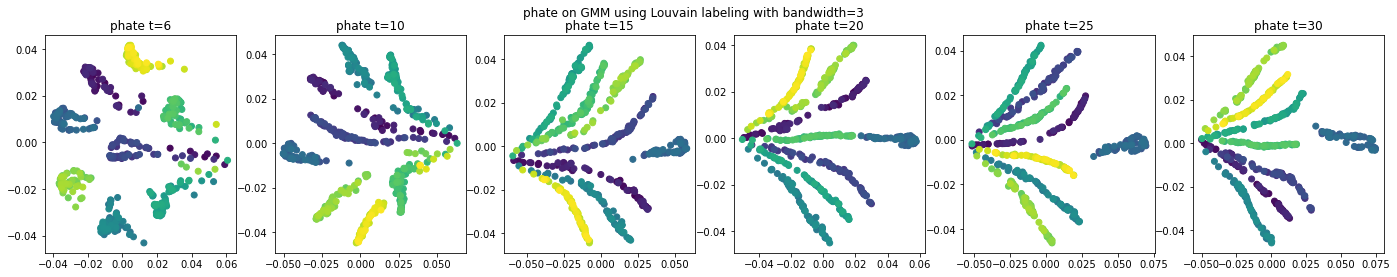

In [68]:
# GMM dataset
fig, axes = plt.subplots(1,n_example)
fig.set_size_inches(24,4)
for i in range(n_example):
    GMM_phate = phate.PHATE(t = int(t_range[i])).fit_transform(gauss_kernel_GMM_list[2]) # gauss_kernel_GMM_list = 2 means bandwidth = 3
    axes[i].scatter(GMM_phate[:,0], GMM_phate[:,1], c=GMM_Louvain_list[2][0]) # GMM_Louvain_list index = 2 means bandwidth = 3
    axes[i].set_title('phate t={}'.format(int(t_range[i])))

fig.suptitle('phate on GMM using Louvain labeling with bandwidth=3')
fig.savefig(os.path.join(path_figures,'Section7-8.pdf'))

Calculating PHATE...
  Running PHATE on 1000 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 22.11 seconds.
Calculated PHATE in 22.51 seconds.
Calculating PHATE...
  Running PHATE on 1000 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  C

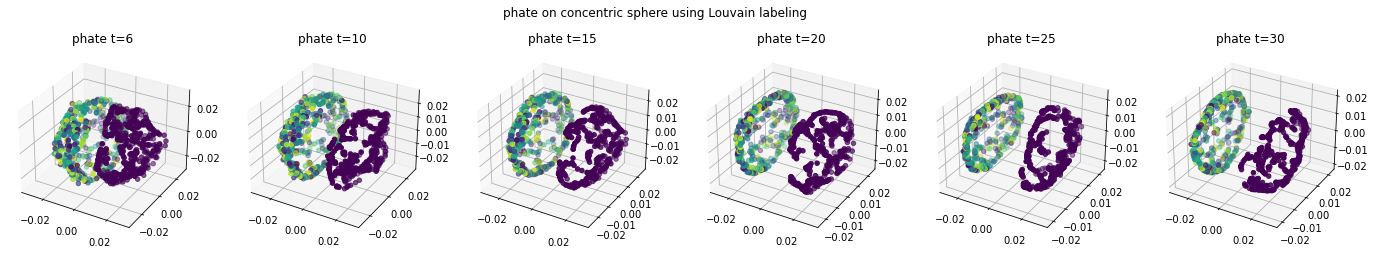

In [69]:
# concentric sphere
fig = plt.figure()
fig.set_size_inches(24,4)

for i in range(n_example):
    sphere_phate = phate.PHATE(n_components=3, t = int(t_range[i])).fit_transform(gauss_kernel_sphere_concentric)
    axes = fig.add_subplot(1,n_example,i+1, projection = '3d')
    axes.scatter(sphere_phate[:,0], sphere_phate[:,1], sphere_phate[:,2], c=sphere_Louvain_list[0])
    axes.set_title('phate t={}'.format(int(t_range[i])))

fig.suptitle('phate on concentric sphere using Louvain labeling')
fig.savefig(os.path.join(path_figures,'Section7-9.pdf'))

### Question 7.1 How does Louvain compare to the output of the two previous clustering methods we tried (spectral and regular k-means)?
Answer: The Louvain performs similar to the spectral clustering and performs better than regular k-means.

### Question 7.2 What is the goal of Louvain?
Answer: The goal of Louvain is to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities.

### Question 7.3 How does Louvain perform on SBM at various pij and pii?
Answer: Louvain performs well robustly on SBM at various pij and pii. 

### Question 7.4 What effects did you observe when varying the parameters of tSNE? Why do you think these changes occurred? Did you find an optimal set of parameters for visualization, or did this depend on the specific clusters?
Answer: When varying the perplexity parameter of tSNE, I noticed that with increasing perplexity, the clusters are pushed more far away in GMM and concentric sphere but not in SBM. The visualization is dependent on specific cluster.

### Question 7.5 What effects did you observe when varying the parameters of PHATE? Why do you think these changes occurred? Was there an optimal set of parameters for all visualizations?
Answer: When varying the perplexity parameter of tSNE, I noticed that with increasing t, the clusters are pushed more far away. There is not an optimal set of parameters for all datasets.

### Question 7.6 What differences did you notice between tSNE and PHATE? Theoretically, what do you think accounts for them?
Answer: tSNE is sensitive to noise while phate is less sensitive as it creates a low-dimensional embedding speicific for visualization. 

### Question 7.7 Why is the Gaussian mixture model a good data set to use to test the clustering algorithm?
Answer: The advantage of using Gaussian mixture models is that they do not require which subpopulation a data point belongs to and allows model to learn the subpopulations automatically.

### Question 7.8 What modifications to the mixture model would you make to further test the clustering algorithms?
Answer: I will try the adaptive kernel and vary k in the Gaussian mixture model to further test the clustering algorithms.

### Question 7.9 What are other synthetic data sets you would use to test clustering algorithms?
Answer: We can use skewed Gaussian distribution model to test clustering algorithms.

# 8 Retinal Bipolar dataset
### 1. Load the Retinal Bipolar dataset and its meta data from the corresponding files retinal-bipolar-data.pickle and retinal-bipolar-metadata.pickle in the data folder. You should import the pandas data storage library to do this, as you can then use the command pandas.read pickle(‘file-path’). (Note that the metadata actually contains 26 cluster labels, though Shekhar only found 15 of them to be biologically significant.)

In [72]:
import pickle

path_RB_root = os.getcwd().replace('code','data')

with open(os.path.join(path_RB_root, 'retinal-bipolar-data.pickle'), 'rb') as f:
    RB_data = pickle.load(f)

with open(os.path.join(path_RB_root, 'retinal-bipolar-metadata.pickle'), 'rb') as f:
    RB_meta_data = pickle.load(f)

### 2. The unaltered dataset has over 15,000 columns corresponding to 15,000 markers for each of the 21,000 cells. To make the computations feasible on your laptop, we’ll apply PCA to the columns of the dataset, and project each cell onto just the first 100 PCA components. You may wish to use the command scprep.reduce.pca from the scprep library.


In [74]:
import scprep

RB_data_PCA = scprep.reduce.pca(RB_data, n_components=100, method='dense')

### 3. 1,000 cells is still quite a few, so we’ll subsample down to 3000 cells. You can use the function scprep.select.subsample to randomly select 3000 cells and their corresponding markers from from the dataset and its metadata.

In [75]:
subsample_RB_data_PCA, subsample_RB_meta = scprep.select.subsample(RB_data_PCA, RB_meta_data, n = 3000)

### 4. Build a graph from the dimensionally-reduced data using an adaptive Gaussian kernel with k = 10.

In [77]:
A_RB_matrix = gaussian_kernel(subsample_RB_data_PCA, k=10)

fixed bandwidth specified


### 5. Cluster the data using k-means, Spectral Clustering and Louvain.

In [82]:
numOfCluster = 26
# use k-means 
RB_kmeans_labels = kmeans(subsample_RB_data_PCA.values, k=numOfCluster)

# use Spectral Clustering 
RB_L_matrix = L(A_RB_matrix)
RB_SC_labels = SC(RB_L_matrix, k=numOfCluster)

# use Louvain
G = nx.from_numpy_array(A_RB_matrix)
partition_RB = community_louvain.best_partition(G)
RB_louvain_clusters = np.asarray(list(partition_RB.values()))

### 6. Visualize the dimensionally-reduced data using PHATE, coloring the points according to each of the above clusterings. Produce similar visualizations using tSNE. What differences do you notice between the visualization techniques with this dataset?

In [93]:
# phate
RB_phate = phate.PHATE().fit_transform(subsample_RB_data_PCA)

Calculating PHATE...
  Running PHATE on 3000 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.61 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.35 seconds.
  Calculated landmark operator in 13.27 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 5.49 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.18 seconds.
Calculated PHATE in 24.89 seconds.


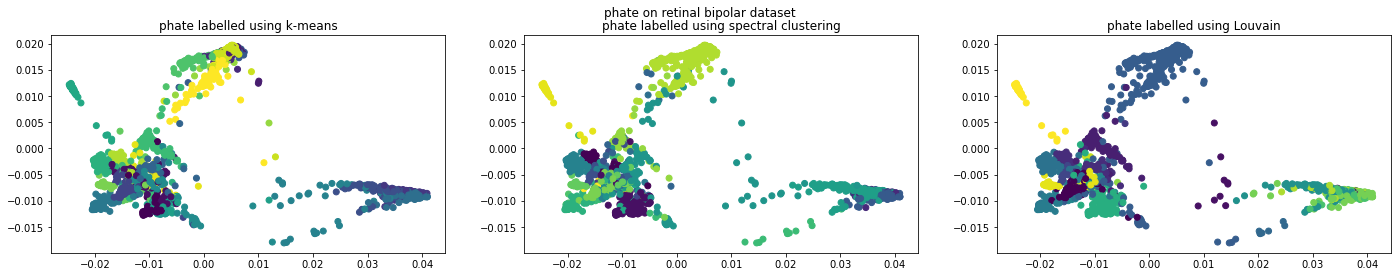

In [94]:
n_methods = 3
cluster_list = []
cluster_list.append(RB_kmeans_labels)
cluster_list.append(RB_SC_labels)
cluster_list.append(RB_louvain_clusters)

cluster_name = ['k-means', 'spectral clustering', 'Louvain']

fig, axes = plt.subplots(1,n_methods)
fig.set_size_inches(24,4)
for i in range(n_methods):
    axes[i].scatter(RB_phate[:,0], RB_phate[:,1], c=cluster_list[i])
    axes[i].set_title('phate labelled using {}'.format(cluster_name[i]))

fig.suptitle('phate on retinal bipolar dataset')
fig.savefig(os.path.join(path_figures,'Section8-1.pdf'))

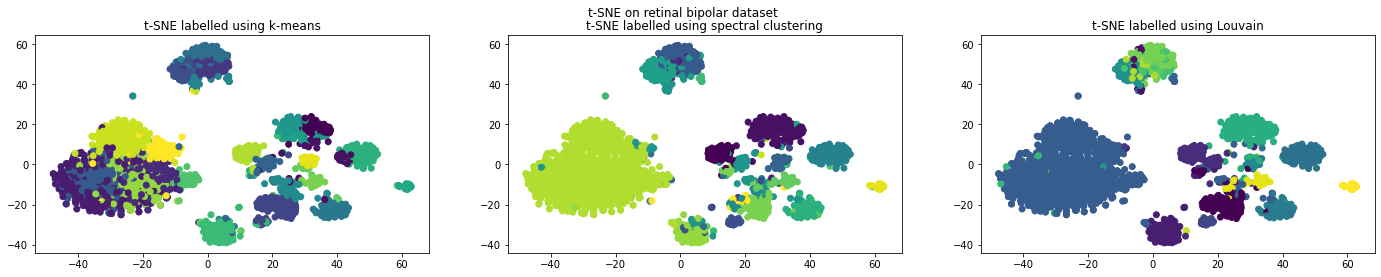

In [95]:
# t-SNE
RB_tsne = TSNE().fit_transform(subsample_RB_data_PCA)

fig, axes = plt.subplots(1,n_methods)
fig.set_size_inches(24,4)
for i in range(n_methods):
    axes[i].scatter(RB_tsne[:,0], RB_tsne[:,1], c=cluster_list[i])
    axes[i].set_title('t-SNE labelled using {}'.format(cluster_name[i]))

fig.suptitle('t-SNE on retinal bipolar dataset')
fig.savefig(os.path.join(path_figures,'Section8-2.pdf'))

### 7. Try varying the kernel parameter k to obtain different cluster assignments. Additionally vary the Louvain parameters. Visualize each of these new clusterings with a recolored PHATE plot.

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


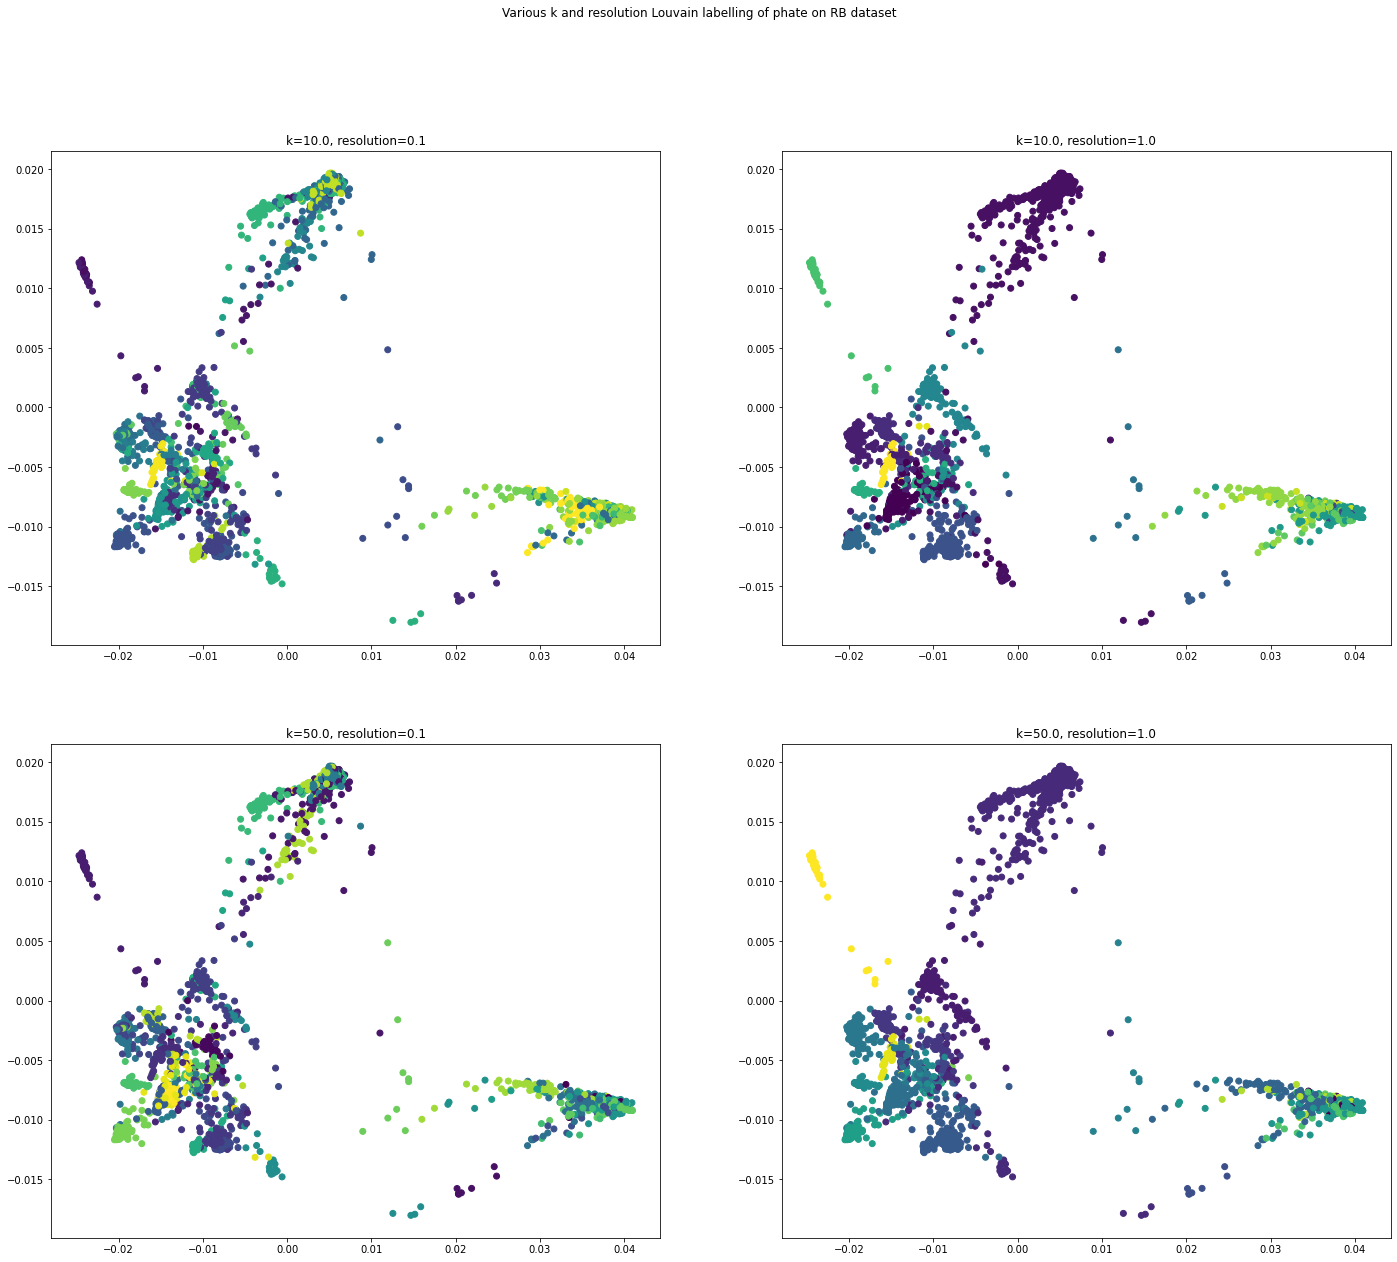

In [97]:
n_step = 2
k_list = [k for k in np.linspace(10, 50, n_step)]
resolution_list = [resolution for resolution in np.linspace(0.1, 1, n_step)]

fig, axes = plt.subplots(n_step,n_step)
fig.set_size_inches(24,20)

for i in range(n_step):
    for j in range(n_step):
        A_RB_matrix = gaussian_kernel(subsample_RB_data_PCA, k=k_list[i])
        RB_louvain_clusters = func_Louvain(A_RB_matrix, resolution_list[j])
        axes[i][j].scatter(RB_phate[:,0], RB_phate[:,1], c=RB_louvain_clusters)
        axes[i][j].set_title('k={k}, resolution={resolution}'.format(k=k_list[i], resolution=resolution_list[j]))
        
fig.suptitle('Various k and resolution Louvain labelling of phate on RB dataset')
fig.savefig(os.path.join(path_figures,'Section8-3.pdf'))

### 8. Plot the second and third eigenvectors of the Graph Laplacian. Color the plot by your cluster assign- ments.

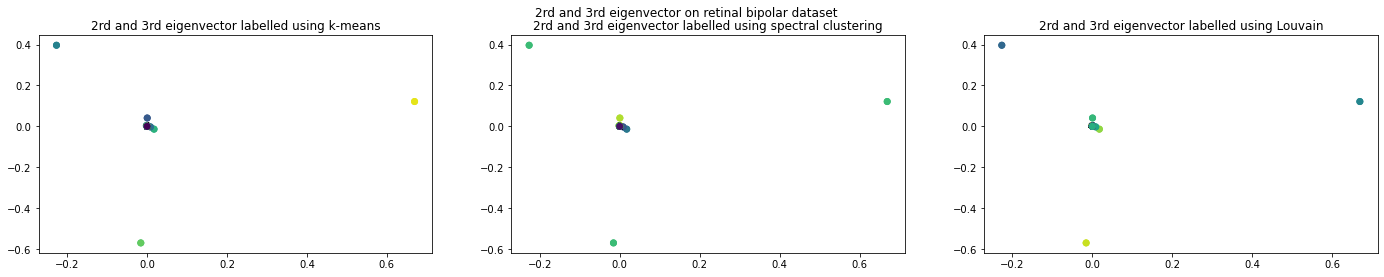

In [99]:
RB_e, RB_psi = compute_fourier_basis(RB_L_matrix)

fig, axes = plt.subplots(1,n_methods)
fig.set_size_inches(24,4)
for i in range(n_methods):
    axes[i].scatter(RB_psi[:,1], RB_psi[:,2], c=cluster_list[i])
    axes[i].set_title('2rd and 3rd eigenvector labelled using {}'.format(cluster_name[i]))

fig.suptitle('2rd and 3rd eigenvector on retinal bipolar dataset')
fig.savefig(os.path.join(path_figures,'Section8-4.pdf'))

### 9. Try coloring the PHATE plot using different channels in the data (e.g. different columns of the metadata matrix). Can you find any channels that seem to correspond to your cluster assignments?

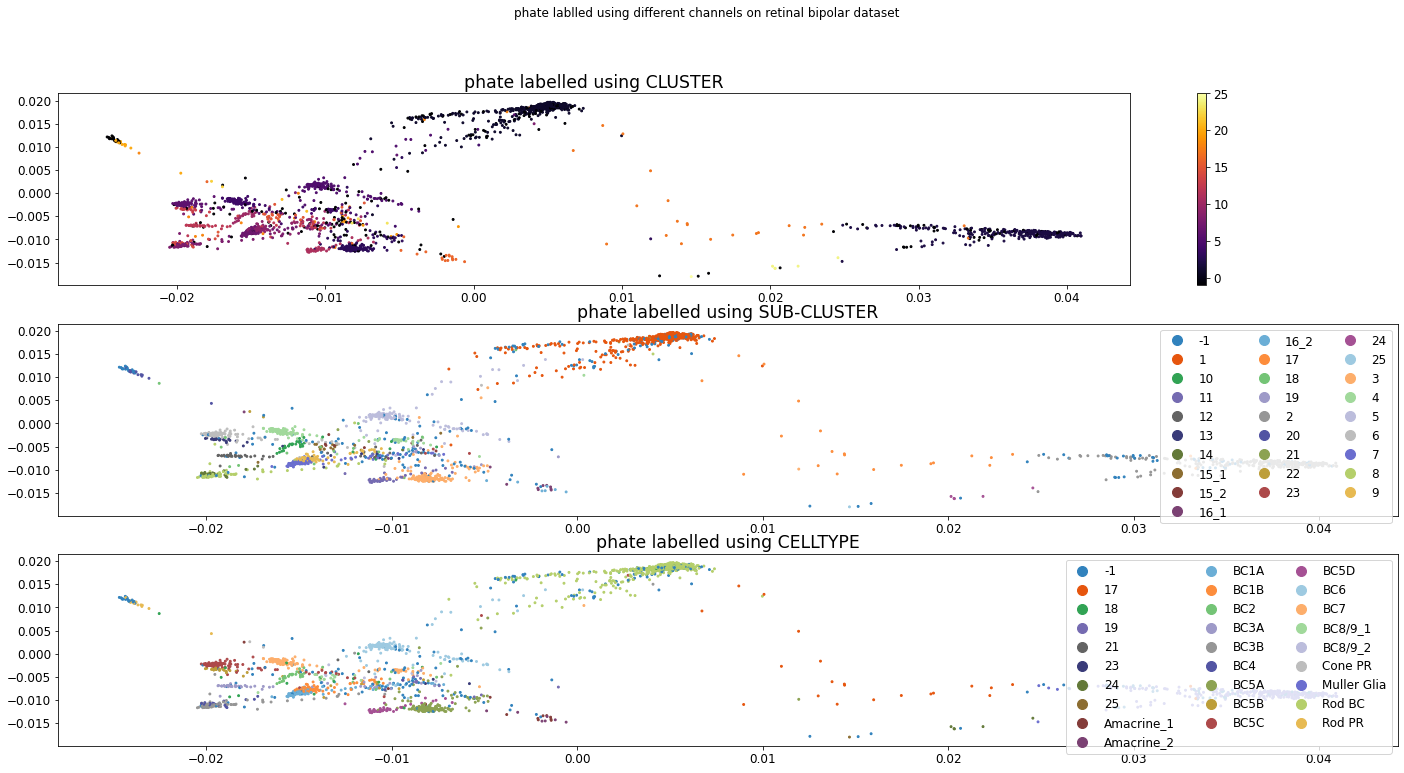

In [132]:
meta_list = ['CLUSTER','SUB-CLUSTER','CELLTYPE']
n_meta = len(meta_list)
fig, axes = plt.subplots(n_meta, 1)
fig.set_size_inches(24,12)

for i in range(n_meta):
    scatter2d(RB_phate, c=subsample_RB_meta[meta_list[i]], title='phate labelled using {}'.format(meta_list[i]), ax=axes[i])

fig.suptitle('phate lablled using different channels on retinal bipolar dataset')
fig.savefig(os.path.join(path_figures,'Section8-5.pdf'))

### 10. Apply an ideal low-pass filter to some of the channels you found above, treating the gene expression as a signal over the graph. Rerun your visualizations using these new, filtered channels to color the PHATE plot. How much has changed? Do any of the denoised channels better represent the true clustering?

In [113]:
A = gaussian_kernel(subsample_RB_data_PCA, k = 10)
L = L(A)
e, psi = compute_fourier_basis(L)
H = filterbank_matrix(psi, e, "low-pass") # (3000, 3000)

filtered_subsample_RB_data_PCA = H @ subsample_RB_data_PCA

fixed bandwidth specified


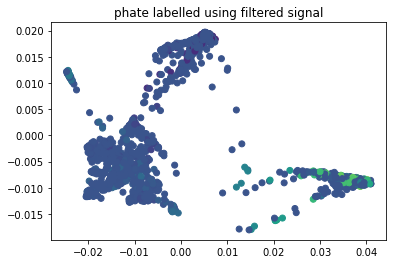

In [118]:
fig, axes = plt.subplots(1,1)
axes.scatter(RB_phate[:,0], RB_phate[:,1], c=filtered_subsample_RB_data_PCA['PC1'])
axes.set_title('phate labelled using filtered signal PC1')

# fig.suptitle('phate lablled using different channels on retinal bipolar dataset')
fig.savefig(os.path.join(path_figures,'Section8-6.pdf'))

### 11. Binarize the kernel such that it is no longer a weighted graph (i.e., if a value is greater than some threshold, it is 1, otherwise, it is 0). Try rerunning Louvain with this binarized kernel.

In [124]:
A = gaussian_kernel(subsample_RB_data_PCA, sigma=1)
A_binary = np.where(A > np.mean(A), 1, 0)
RB_louvain_binary = func_Louvain(A_binary)

fixed bandwidth specified
invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth


### 12. Finally, compare your clusters to those of Shekhar et al. by coloring your PHATE visualizations with the cluster number provided in the metadata file. Describe any relationships you notice between these clusters and the clusters you’ve obtained with k-means, Louvain, and Spectral Clustering.

/Users/xiaoranzhang/opt/anaconda3/envs/py_std/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


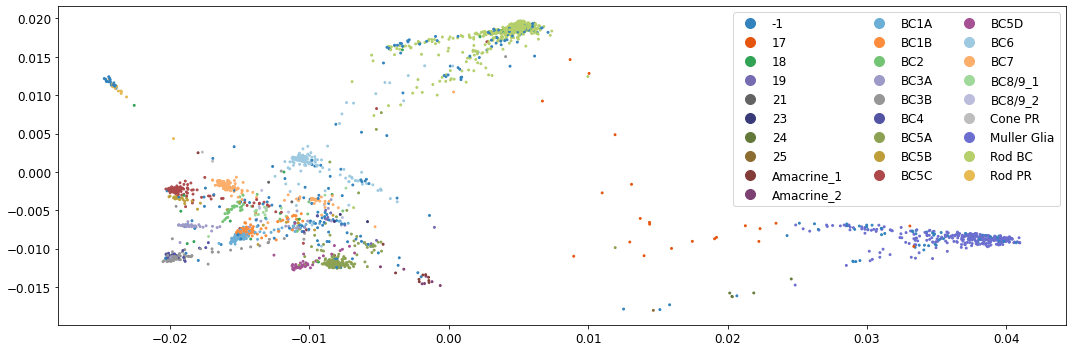

In [133]:
from scprep.plot import scatter2d

scatter2d(RB_phate, c=subsample_RB_meta['CELLTYPE'], figsize=(15,5))
fig.savefig(os.path.join(path_figures,'Section8-7.pdf'))

### Question 8.1 How many clusters did Louvain produce? How many clusters did PHATE and tSNE suggest? To what extent did different clustering methods parameters affect this number?
Answer: I produced 26 clusters. Phate and tsne produced similar amount of clusters. The parameters such as t and k change alot on the cluster results.

### Question 8.2 In a biological setting, how would you interpret the different clusters? More specifically, how would you interpret any variation you noticed from the 15 clusters described by Shekhar et al?
Answer: Different clusters show the single cell variation in terms of genes.

### Question 8.3 What did you notice when you plotted the eigenvectors of the Graph Laplacian?
Answer: I noticed that the eigenvectors are orthogonal to each other in the Graph Laplacian.

### Question 8.4 What is the effect of low-pass filtering a feature on the graph? In what context could this be useful for data analysis?
Answer: Low pass filter acts similar to a smoothing operation by only allowing low frequency components. If we want the cluster to be similar to the original data, we can use low pass filter.

### Question 8.5 How does binarization of the kernel affect your clustering? Why might this be the case?
Answer: Binarization reduces the number of clusters as it reduces the information in the adjacency matrix.